# Task

Analysis of people involvement in spreading ideas through the "success" (no) of "Noon Against Putin” protests.

## Data used

Turnout data collected by Roman Udot - https://twitter.com/romanik_/status/1769626338464284719

## Idea

We can (approximately) know amount of people seeing media mentioning this "Noon Against Putin” stuff.

So:
- if the amount of people here were lower than amount of readers/viewers/etc - than it failed. Means per one viewer of their media there will be less than one participant
- if the amount of people here are roughly similar to the amount of readers/viewers/etc - than it means there are no transfer of their ideas outside their echo chamber
- if the amount of people here are signgificantly more - than... okay

How will we get the amount of people taking part in this protests?

Well, we may use turnout-time data as an indicator. If people collected here after 12:00 17/03/2024 and casted their vote it means that turnout after 12:00 17/03/2024 must be bigger than it is expected.

But the problem is that we need some reference turnout to see how people will behave. Good thing it seems we can approximate turnout using linear regression of two features
- how much time passed since the (3 days) election start
- how much time passed since the beginning of this day

## Result

No noticeable proof of additional turnout.

## Implementation

In [68]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [33]:
workday_start_time = pd.to_timedelta('08:00:00')

df = pd.read_csv("data/turnout-converted.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.loc[~pd.isna(df["turnout_percent"])]

df.head()

,region,tik,uik,time,turnout_percent
0,Алтайский край,Алейская,УИК №554,2024-03-15 15:00:00,19.58
1,Алтайский край,Алейская,УИК №554,2024-03-15 20:00:00,27.19
2,Алтайский край,Алейская,УИК №554,2024-03-16 15:00:00,50.00
3,Алтайский край,Алейская,УИК №554,2024-03-16 20:00:00,59.89
4,Алтайский край,Алейская,УИК №554,2024-03-17 10:00:00,60.65


In [44]:
df["time"].unique()

<DatetimeArray>
['2024-03-15 15:00:00', '2024-03-15 20:00:00', '2024-03-16 15:00:00',
 '2024-03-16 20:00:00', '2024-03-17 10:00:00', '2024-03-17 12:00:00',
 '2024-03-17 15:00:00', '2024-03-17 18:00:00']
Length: 8, dtype: datetime64[ns]

## Approximating expected turnout

Since we do not have a turnout data per time for another 3 day elections to make a reference of human behaviour here - let's see if we can make a linear model using simple time based features (expecting people to come in +/- similar rate over the whole period but keeping the time of day in mind).

### Feature preparation

In [34]:
df["time_from_the_start_hours"] = (df["time"] - pd.to_datetime("15.03.2024 00:00:00", dayfirst=False)).apply(lambda diff: diff.total_seconds() / 3600)
df['time_since_the_workday_start'] = (
    df['time'] - (df['time'].dt.date.astype('datetime64[ns]') + workday_start_time)
).apply(lambda diff: diff.total_seconds() / 3600)
df.head()

/tmp/ipykernel_15226/2316303731.py:1: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["time_from_the_start_hours"] = (df["time"] - pd.to_datetime("15.03.2024 00:00:00", dayfirst=False)).apply(lambda diff: diff.total_seconds() / 3600)


,region,tik,uik,time,turnout_percent,time_from_the_start_hours,time_since_the_workday_start
0,Алтайский край,Алейская,УИК №554,2024-03-15 15:00:00,19.58,15.0,7.0
1,Алтайский край,Алейская,УИК №554,2024-03-15 20:00:00,27.19,20.0,12.0
2,Алтайский край,Алейская,УИК №554,2024-03-16 15:00:00,50.00,39.0,7.0
3,Алтайский край,Алейская,УИК №554,2024-03-16 20:00:00,59.89,44.0,12.0
4,Алтайский край,Алейская,УИК №554,2024-03-17 10:00:00,60.65,58.0,2.0


In [37]:
df_agg = df.groupby(['time', 'time_from_the_start_hours', 'time_since_the_workday_start'])['turnout_percent'].agg(
    turnout_percent_mean='mean',
    turnout_percent_std='std'
).reset_index()

### Checking the idea

To test the idea I will:

- train model using 15.03.2024 data
- test it using 16.03.2024 data

Than I will compare a few things:
- train set MAE error
- test set MAE error
- MAE between the turnout and time-averaged turnout for the test set

In [84]:
mask_train = df["time"] < pd.to_datetime("2024-03-16 10:00")
regression = Pipeline([
    ("scaler", StandardScaler()),
    ("predictor", Ridge())
])
regression.fit(df.loc[mask_train, ["time_from_the_start_hours", "time_since_the_workday_start"]],
               df.loc[mask_train, "turnout_percent"])

Pipeline(steps=[('scaler', StandardScaler()), ('predictor', Ridge())])

In [85]:
regression.steps[-1][1].coef_

array([3.24514927, 3.24514927])

In [86]:
mask_test = df["time"] == pd.to_datetime("2024-03-16 20:00")

In [87]:
mean_absolute_error(
    y_true=df.loc[mask_train, "turnout_percent"],
    y_pred=regression.predict(df.loc[mask_train, ["time_from_the_start_hours", "time_since_the_workday_start"]])
)

11.14579415095455

In [88]:
mean_absolute_error(
    y_true=df.loc[mask_test, "turnout_percent"],
    y_pred=regression.predict(df.loc[mask_test, ["time_from_the_start_hours", "time_since_the_workday_start"]])
)

14.215444080596418

In [89]:
mean_absolute_error(
    y_true=df.loc[mask_test, "turnout_percent"],
    y_pred=[df.loc[mask_test, "turnout_percent"].mean()] * sum(mask_test)
)

12.630726247900226

So it seems model MAE error is not much different from the deviations withing election commission turnout data.

### Training model

In [91]:
mask_train = df["time"] < pd.to_datetime("2024-03-17 12:00")
regression = Pipeline([
    ("scaler", StandardScaler()),
    ("predictor", Ridge())
])
regression.fit(df.loc[mask_train, ["time_from_the_start_hours", "time_since_the_workday_start"]],
               df.loc[mask_train, "turnout_percent"])

Pipeline(steps=[('scaler', StandardScaler()), ('predictor', Ridge())])

In [94]:
df_agg["linear_model_predicted_turnout"] = regression.predict(df_agg[["time_from_the_start_hours", "time_since_the_workday_start"]])
df_agg.head()

,time,time_from_the_start_hours,time_since_the_workday_start,turnout_percent_mean,turnout_percent_std,linear_model_predicted_turnout
0,2024-03-15 15:00:00,15.0,7.0,25.660753,14.824293,26.571321
1,2024-03-15 20:00:00,20.0,12.0,38.654877,15.797645,38.257713
2,2024-03-16 15:00:00,39.0,7.0,53.139983,15.729758,51.135063
3,2024-03-16 20:00:00,44.0,12.0,61.911677,15.442154,62.821454
4,2024-03-17 10:00:00,58.0,2.0,63.470117,16.070776,64.012413


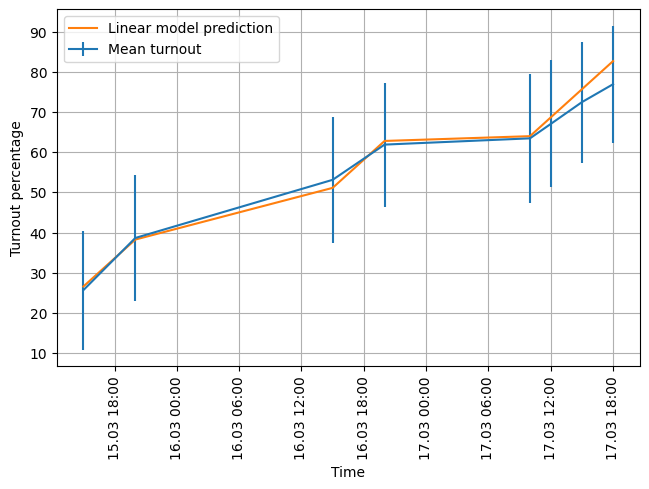

In [96]:
plt.errorbar(df_agg["time"],
             df_agg["turnout_percent_mean"],
             yerr=df_agg["turnout_percent_std"],
             label="Mean turnout")
plt.plot(df_agg["time"],
         df_agg["linear_model_predicted_turnout"],
         label="Linear model prediction")

# Improve date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation='vertical')
plt.grid()
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area

plt.xlabel("Time")
plt.ylabel("Turnout percentage")
plt.legend()
plt.show()

Okay, I guess no point in further analysis.

There is no noticeable sign of additional turnout, I see.